In [77]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report , roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
df = pd.read_csv("../data/trainDRUG.csv")

In [3]:
df.head()

,性別,教育,神智,年齡,每月採尿平均,實際保管長度,違規次數,獎勵次數,犯次,一年內次數,二年內次數,三年內次數,四年內次數,五年內次數,首犯年齡,再犯註記
0,1,4,3,3,2.333,1,0,0,5,0,0,0,3,4,0,0
1,1,3,2,3,0.000,1,0,0,2,0,0,0,1,0,0,0
2,1,3,2,3,1.000,3,0,2,4,0,0,0,0,0,1,0
3,1,3,0,4,1.714,1,0,0,5,0,0,0,0,0,1,1
4,1,3,0,3,0.871,4,0,1,2,0,0,0,0,0,0,0


In [4]:
df['再犯註記'].value_counts()

0    53906
1    11496
Name: 再犯註記, dtype: int64

In [5]:
X = df.drop(['再犯註記'], axis=1)
y = df['再犯註記']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2, stratify=y)

In [7]:
y_train.value_counts()

0    43124
1     9197
Name: 再犯註記, dtype: int64

In [76]:
y_test.value_counts()

0    10782
1     2299
Name: 再犯註記, dtype: int64

In [8]:
u = RandomUnderSampler(random_state=42, sampling_strategy={0:30000})
o = SMOTE()
m = RandomForestClassifier(random_state=42)

In [9]:
pipeline = Pipeline([
    ('undersampler', u),
    ('oversampler', o),
    ('model', m)
])

In [10]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy={0: 30000})),
                ('oversampler', SMOTE()),
                ('model', RandomForestClassifier(random_state=42))])

In [11]:
prediction = pipeline.predict(X_test)

In [12]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     10782
           1       0.37      0.49      0.42      2299

    accuracy                           0.76     13081
   macro avg       0.63      0.66      0.64     13081
weighted avg       0.79      0.76      0.78     13081



In [13]:
u_strategy = [
    {0:50000},
    {0:40000},
    {0:30000},
    {0:20000},
    {0:10000},
    {0:5000}
]

In [14]:
o_strategy = [
    {1:50000},
    {1:40000},
    {1:30000},
    {1:20000},
    {1:10000},
    {1:5000}
]

In [15]:
hp_pipeline = Pipeline([
    ('undersampler', u),
    ('oversampler',o),
    ('model',m)
])

In [16]:
grid_params = {
    'undersampler__sampling_strategy': u_strategy,
    'oversampler__sampling_strategy': o_strategy
}

In [17]:
clf = GridSearchCV(estimator = hp_pipeline, param_grid = grid_params)

In [18]:
%%capture
clf.fit(X_train, y_train)

In [19]:
clf.best_params_

{'oversampler__sampling_strategy': {1: 10000},
 'undersampler__sampling_strategy': {0: 30000}}

In [20]:
hp_best_pipeline = clf.best_estimator_

In [21]:
hp_best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy={0: 30000})),
                ('oversampler', SMOTE(sampling_strategy={1: 10000})),
                ('model', RandomForestClassifier(random_state=42))])

In [22]:
predict_hp = hp_best_pipeline.predict(X_test)

In [23]:
print(classification_report(y_test, predict_hp))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     10782
           1       0.51      0.33      0.40      2299

    accuracy                           0.83     13081
   macro avg       0.69      0.63      0.65     13081
weighted avg       0.80      0.83      0.81     13081



In [24]:
pred_hp_proba = hp_best_pipeline.predict_proba(X_test)[:, 1]

In [37]:
fpr, tpr, _ = roc_curve(y_test, pred_hp_proba)
auc = round(roc_auc_score(y_test, pred_hp_proba), 4)
print(auc)

0.7606


from sklearn.externals import joblib
joblib.dump(hp_best_pipeline, 'modelexe1.pkl')

import pickle

with open('modelfile.pkl', 'wb') as f:
    pickle.dump(hp_best_pipeline, f)

with open('modelfile.pkl', 'rb') as f:
    mm = pickle.load(f)

mm.predict_proba(X_test)[:, 1]

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(0).clf()
plt.style.use("ggplot")

plt.plot(fpr,tpr,label="oversampling with SMOTE+under, AUC="+str(auc))

plt.legend(loc=0)
plt.title("模型比較(AUC)")
plt.xlabel("fpr")
plt.ylabel("tpr")

In [27]:
train_X = X_train
train_y = y_train
test_X = X_test
test_y = y_test

In [29]:
target_names = ['未再犯','再犯']

In [38]:
# 基本模型/原始資料
model1 = RandomForestClassifier(random_state=42, n_jobs=-1)
model1.fit(train_X, train_y)
y_pred = model1.predict_proba(test_X)[:, 1]
predict_y = model1.predict(test_X)
fpr1, tpr1, _ = roc_curve(test_y, y_pred)
auc1 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         未再犯       0.86      0.96      0.91     10782
          再犯       0.59      0.26      0.36      2299

    accuracy                           0.84     13081
   macro avg       0.72      0.61      0.63     13081
weighted avg       0.81      0.84      0.81     13081



In [39]:
# RF model with balanced class weight
model2 = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
model2.fit(train_X, train_y)
y_pred = model2.predict_proba(test_X)[:, 1]
predict_y = model2.predict(test_X)
fpr2, tpr2, _ = roc_curve(test_y, y_pred)
auc2 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         未再犯       0.86      0.95      0.90     10782
          再犯       0.55      0.26      0.35      2299

    accuracy                           0.83     13081
   macro avg       0.70      0.61      0.63     13081
weighted avg       0.80      0.83      0.81     13081



In [93]:
# RF model with balanced subsample class weight
model3 = RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1)
model3.fit(train_X, train_y)
y_pred = model3.predict_proba(test_X)[:, 1]
predict_y = model3.predict(test_X)
fpr3, tpr3, _ = roc_curve(test_y, y_pred)
auc3 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         未再犯       0.86      0.96      0.90     10782
          再犯       0.56      0.26      0.35      2299

    accuracy                           0.83     13081
   macro avg       0.71      0.61      0.63     13081
weighted avg       0.81      0.83      0.81     13081



In [92]:
# RF with SMOTE
from sklearn.metrics import precision_recall_fscore_support
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(train_X, train_y) #X, y
model4 = RandomForestClassifier(random_state=42, n_jobs=-1)
model4.fit(X_over, y_over)
y_pred = model4.predict_proba(test_X)[:, 1]
predict_y = model4.predict(test_X)
fpr4, tpr4, _ = roc_curve(test_y, y_pred)
auc4 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))
prf = precision_recall_fscore_support(test_y, predict_y)
print(prf)
cm = confusion_matrix(test_y, predict_y)
print(cm)
aa = accuracy_score(test_y, predict_y)
print(aa)

              precision    recall  f1-score   support

         未再犯       0.88      0.85      0.86     10782
          再犯       0.39      0.45      0.42      2299

    accuracy                           0.78     13081
   macro avg       0.63      0.65      0.64     13081
weighted avg       0.79      0.78      0.78     13081

(array([0.87857829, 0.38749532]), array([0.84826563, 0.45019574]), array([0.86315591, 0.41649899]), array([10782,  2299], dtype=int64))
[[9146 1636]
 [1264 1035]]
0.778304410977754


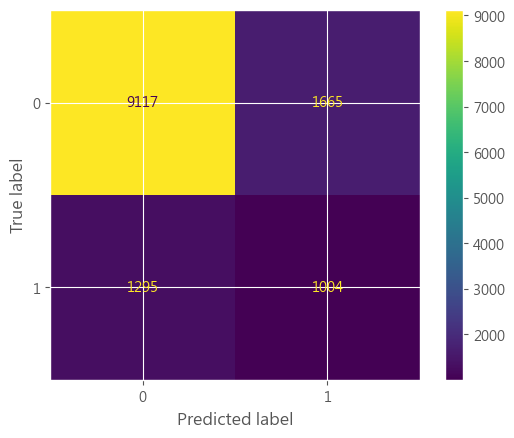

In [75]:
ConfusionMatrixDisplay.from_predictions(test_y, predict_y, colorbar=True)
plt.show()

In [51]:
print(prf[0][0])

0.8757888697647733


Text(0, 0.5, 'tpr')

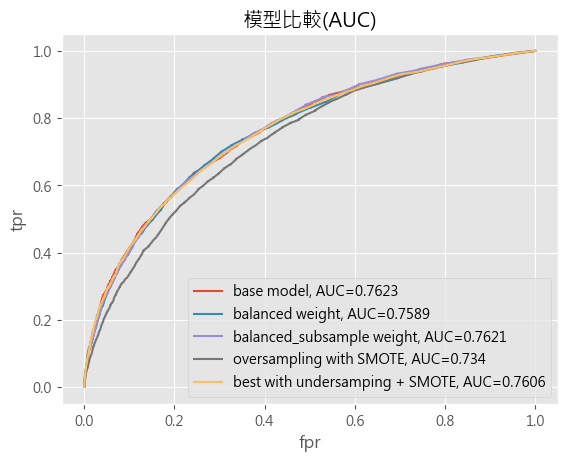

In [36]:
# plot ROC_AUC graph
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(0).clf()
plt.style.use("ggplot")

plt.plot(fpr1,tpr1,label="base model, AUC="+str(auc1))
plt.plot(fpr2,tpr2,label="balanced weight, AUC="+str(auc2))
plt.plot(fpr3,tpr3,label="balanced_subsample weight, AUC="+str(auc3))
plt.plot(fpr4,tpr4,label="oversampling with SMOTE, AUC="+str(auc4))
plt.plot(fpr,tpr,label="best with undersamping + SMOTE, AUC="+str(auc))

plt.legend(loc=0)
plt.title("模型比較(AUC)")
plt.xlabel("fpr")
plt.ylabel("tpr")

In [89]:
results = pd.DataFrame(columns=['模型','準確率','精確率', '招回率','f1_score', 'support'], index=['非再犯','再犯'])

In [90]:
results['準確率']['非再犯']=0.9

In [ ]:
models = [model3, model4]
modelName = ['RF+原始資料','RF+balanced weight', 'RF+balanced subsample']
k=1
for m in models:
    predict_y = m.predict(test_X)
    acc = accuracy_score(test_y, predict_y)
    prf = precision_recall_fscore_support(test_y, predict_y)
    results['模型']['非再犯']=modelName[k-1]
    results['模型']['再犯']=modelName[k-1]
    results['準確率']['非再犯']=acc
    results['準確率']['再犯']=acc
    results['精確率']['非再犯']=prf[0][0]
    results['精確率']['再犯']=prf[0][1]
    results['招回率']['非再犯']=prf[1][0]
    results['招回率']['再犯']=prf[1][1]
    results['f1_score']['非再犯']=prf[2][0]
    results['f1_score']['再犯']=prf[2][1]
    results['support']['非再犯']=prf[3][0]
    results['support']['再犯']=prf[3][1]
    k=k+1

    

In [107]:
list = ['model1', 0.9, 0.8, 0.8, 0.8, 10000]
results.loc[len(results)]=list
results

,模型,準確率,精確率,招回率,f1_score,support
非再犯,RF+balanced weight,0.778304,0.878578,0.848266,0.863156,10782
再犯,RF+balanced weight,0.778304,0.387495,0.450196,0.416499,2299
2,model1,0.9,0.8,0.8,0.8,10000
3,model1,0.9,0.8,0.8,0.8,10000
